<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# TP1 Instructions


The goal of this TP is to work on a mortality prediction problem and to participate into the "To be or not to be?" challenge.

A fresh instance of the challenge can be found here: https://competitions.codalab.org/competitions/27605

* **Step 1:** Sign up to https://competitions.codalab.org
* **Step 2:** Go through the competition's pages and read them carefully in order to understand the problem.
* **Step 3:** Download the dataset from "Participate > Files > Public Data" page. Put the "public_data" folder in the same folder as the folder containing this notebook.
* **Step 4:** Go though this notebook. You'll have to read, run, **code your own methods** and **answer quetions**. Use "code" cell for coding and "markdown" cell to answer questions. 


<b><font size="5">Outline</font></b><br/><br/>
&emsp;&emsp;&emsp; I) <a href="#data"> Load data</a><br/>
&emsp;&emsp;&emsp; II) <a href="#exploratory"> Exploratory analysis </a><br/>
&emsp;&emsp;&emsp; III) <a href="#preprocessing"> Preprocessing </a><br/>
&emsp;&emsp;&emsp; IV) <a href="#processing"> Processing </a><br/>
&emsp;&emsp;&emsp; V) <a href="#model"> Predictive model </a><br/>
&emsp;&emsp;&emsp; VI) <a href="#save"> Save predictions </a><br/>

2020 december, 1rst

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import time
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np

import sklearn

# IMPORTS
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    plot_confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.svm import LinearSVC

import os
from pathlib import Path

from IPython.display import display
from pprint import pprint

### Question 1: Briefly explain the task.

This is a binary classification of tabular data.  
From information about patients, we need to predict whether the patients will die during their stay in the hospital.  
A target value of 0 means survival, and 1 means death.

### Question 2: What is the metric used in the challenge?

Balanced accuracy: average of accuracy for each class  

<table>
    <tr>
        <td>
            <img src="https://statisticaloddsandends.files.wordpress.com/2020/01/metrics1.png?w=600&h=434" width="250">
        </td>
        <td>
            <img src="https://statisticaloddsandends.files.wordpress.com/2020/01/metrics2.png?w=768&h=352" width="450">
        </td>
    </tr>
</table>
    
$$ 
\texttt{Recall = Sensitivity = True Positive Rate} \\
= \frac{True Positive}{True Positive + False Negative} = \frac{True Positive}{All Actual Positive}
\\
$$

$$
\texttt{Specificity = True Negative Rate = 1- False Positive Rate} \\
= \frac{True Negative}{True Negative + False Positive} = \frac{True Negative}{All Actual Negative}
\\
$$   

$$
\texttt{balanced-accuracy} = \frac 1 2 (\texttt{True Positive Rate} + \texttt{True Negative Rate})
= \frac{1}{2}\left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right )
\\
$$

Reference:  
https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score  
https://mvpa.blogspot.com/2015/12/balanced-accuracy-what-and-why.html  


Example:  
https://statisticaloddsandends.wordpress.com/2020/01/23/what-is-balanced-accuracy/  


In [2]:
print(os.getcwd())
print(os.listdir("public_data"))

/Users/md_76s/Desktop/Studies/OPT9 - Data Camp/Class 4/OPT9_TP4
['mimic_synthetic_test.data', 'mimic_synthetic_feat.name', 'mimic_synthetic_feat.type', 'mimic_synthetic_test.csv', 'mimic_synthetic_label.name', 'mimic_synthetic_train.solution', 'mimic_synthetic_train.data']


## <a id="data"> I) Load data</a>  

In [3]:
features = pd.read_csv(
    "public_data/mimic_synthetic_feat.name", header=None
).values.flatten()
labels = pd.read_csv(
    "public_data/mimic_synthetic_label.name", header=None
).values.flatten()
X = pd.read_csv(
    "public_data/mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)
y = pd.Series(
    pd.read_csv(
        "public_data/mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [4]:
print(X.shape)
display(X.sample(5))

(79999, 341)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
36506,21015,137866,2108-11-29_20:38:00,2185-07-02_02:08:00,Private,ENGL,JEWISH,SINGLE,WHITE,F,...,0,0,0,0,0,0.0,0,0,0,1
8928,87779,166145,2198-04-13_22:39:00,2197-01-19_15:20:00,Medicare,ENGL,BAPTIST,SINGLE,PATIENT_DECLINED_TO_ANSWER,F,...,0,0,0,0,0,0.0,0,0,1,0
1997,9976,136576,2115-11-04_05:13:00,2144-06-29_16:30:00,Private,ENGL,CATHOLIC,SINGLE,WHITE,M,...,0,0,0,0,0,0.0,0,0,0,0
73291,11864,138363,2185-09-20_19:52:00,2160-10-17_16:09:00,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,...,0,0,0,0,0,0.0,0,0,1,0
62729,67987,154483,2192-06-27_08:00:00,2129-03-23_12:35:00,Medicare,ENGL,BUDDHIST,SINGLE,WHITE,F,...,0,0,0,0,0,0.0,0,0,1,0


In [5]:
print(y.shape)
display(y.sample(5))
display(y.value_counts())

(79999,)


36892    0
59904    0
74549    0
31628    0
41715    0
dtype: int64

0    77202
1     2797
dtype: int64

This is the **training set**. This means that have access to the labels and you can use it in anyway you want to prepare your model.

Later on, you'll make your model draws predictions from the **testing set** in order to upload them on Codalab and get a score on unseen labels.

In [6]:
# Load testing set
X_test = pd.read_csv(
    "public_data/mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

In [7]:
print(X_test.shape)
# print(X_test.dropna().shape)
display(X_test.sample(5))

(20001, 341)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
11913,65180,166673,2154-07-08_14:15:00,2180-07-03_13:30:00,Private,ENGL,CATHOLIC,MARRIED,WHITE,M,...,0,0,0,0,0,0.0,0,0,0,0
18658,21427,185349,2108-10-16_02:27:00,2104-04-30_12:15:00,Medicare,ENGL,CHRISTIAN_SCIENTIST,WIDOWED,WHITE_-_OTHER_EUROPEAN,F,...,0,0,0,0,0,0.0,0,0,1,0
8698,40788,195101,2183-01-27_16:13:00,2106-07-13_13:49:00,Medicare,ENGL,NOT_SPECIFIED,WIDOWED,WHITE,F,...,0,0,0,0,0,1.0,1,0,1,0
300,18807,136156,2197-02-21_00:47:00,2154-04-12_19:41:00,Medicare,ENGL,UNOBTAINABLE,MARRIED,WHITE,F,...,0,0,0,0,0,0.0,0,0,0,1
6602,89402,180916,2109-08-04_17:16:00,2197-09-29_16:44:00,Private,ENGL,CATHOLIC,MARRIED,WHITE,M,...,0,0,0,0,0,0.0,1,0,0,0


## <a id="exploratory"> II) Exploratory analysis</a>

#### Variable types

In [8]:
types = pd.read_csv(
    "public_data/mimic_synthetic_feat.type", header=None
).set_index(features)[0]
print(types.value_counts())

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64


### Code 1: Display the following plots:
* Bar plots of some categorical variables (e.g. "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between some variables and the target variable y.

* Another plot or any exploratory analysis you can think of

In [9]:
# TODO: plot1
display(types[types == "Categorical"].index.values)

categorical_features = "ICU INSURANCE GENDER".split(" ")

array(['ADMITTIME', 'DISCHTIME', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'ICU'], dtype=object)

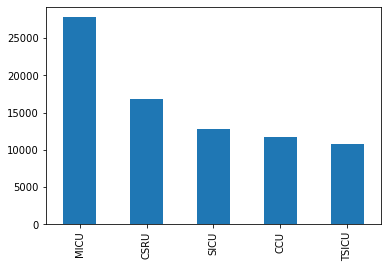

In [10]:
X["ICU"].value_counts().plot(kind="bar")

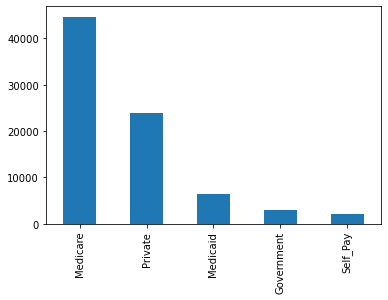

In [11]:
X["INSURANCE"].value_counts().plot(kind="bar")

In [12]:
def split_yindex(xdata, ydata):
    """ Split target y into label 0 and label 1"""
    y1_idx = ydata[ydata==1].index
    y0_idx = np.setdiff1d(ydata.index, y1_idx)
    return y0_idx, y1_idx

yindex = split_yindex(X, y)
print(len(yindex[0]), len(yindex[1]))

77202 2797


In [13]:
def sample_data(xdata, ydata, yindex=None, yratio=4):
    """ Keep all label 1, sample from  label 0 """
    if not yindex: yindex = split_yindex(xdata, ydata)    
    sample_y0_idx = np.random.choice(yindex[0], size=len(yindex[1]) * yratio)    
    sample_idx =  np.concatenate((yindex[1], sample_y0_idx))
    return xdata.iloc[sample_idx], ydata.iloc[sample_idx]

xsample, ysample = sample_data(X, y)
print(xsample.shape, ysample.shape)
display(ysample.value_counts())

(13985, 341) (13985,)


0    11188
1     2797
dtype: int64

In [14]:
xtrain, xvalid, ytrain, yvalid = train_test_split(xsample, ysample, test_size=0.2)


In [15]:
def handle_missing(xdata):
    return xdata.fillna(xdata.median())

xtrain_no_missing = handle_missing(xtrain)
xvalid_no_missing = handle_missing(xvalid)
print(xtrain_no_missing.shape, xvalid_no_missing.shape)

(11188, 341) (2797, 341)


In [16]:
"""
def encode_categorical(xdata):
#     cat_code_cols = []
    cat_cols = "ICU INSURANCE GENDER".split(" ")
    xencd = xdata.copy()
    for cat_col in cat_cols:
        cat_code = cat_col + "_code"
        xencd[cat_code] = xencd[cat_col].astype("category").cat.codes
#         cat_code_cols.append(cat_code)
    xencd = xencd.drop(columns=cat_cols)
    return xencd

# xtrain_encoded, cat_cols = encode_categorical(xtrain_no_missing, categorical_features)
# xvalid_encoded, _ = encode_categorical(xvalid_no_missing, categorical_features)
xtrain_encoded = encode_categorical(xtrain_no_missing)
xvalid_encoded = encode_categorical(xvalid_no_missing)
print(xtrain_encoded.shape)
display(xtrain_encoded.sample(5)["ICU_code"])
"""

'\ndef encode_categorical(xdata):\n#     cat_code_cols = []\n    cat_cols = "ICU INSURANCE GENDER".split(" ")\n    xencd = xdata.copy()\n    for cat_col in cat_cols:\n        cat_code = cat_col + "_code"\n        xencd[cat_code] = xencd[cat_col].astype("category").cat.codes\n#         cat_code_cols.append(cat_code)\n    xencd = xencd.drop(columns=cat_cols)\n    return xencd\n\n# xtrain_encoded, cat_cols = encode_categorical(xtrain_no_missing, categorical_features)\n# xvalid_encoded, _ = encode_categorical(xvalid_no_missing, categorical_features)\nxtrain_encoded = encode_categorical(xtrain_no_missing)\nxvalid_encoded = encode_categorical(xvalid_no_missing)\nprint(xtrain_encoded.shape)\ndisplay(xtrain_encoded.sample(5)["ICU_code"])\n'

In [17]:
cat_sample = X.sample(5)
cat_onehot = pd.get_dummies(cat_sample, columns=["ICU", "INSURANCE"], dummy_na=True)
display(cat_onehot)
print(cat_sample.shape, cat_onehot.shape)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,...,Hrtvalvedx,Carditis,HTN,Htncomplicn,ICU_CSRU,ICU_MICU,ICU_nan,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_nan
1000,9921,147426,2156-02-27_07:15:00,2198-05-16_18:56:00,ENGL,CATHOLIC,MARRIED,WHITE,M,47,...,0,0,1,0,1,0,0,0,1,0
18381,11944,178464,2196-04-28_06:00:00,2197-09-22_16:50:00,ENGL,PROTESTANT_QUAKER,MARRIED,WHITE,M,57,...,0,0,1,0,0,1,0,1,0,0
31558,93571,151079,2168-08-06_15:18:00,2138-06-28_13:13:00,ENGL,CATHOLIC,SINGLE,WHITE,M,83,...,0,0,0,0,0,1,0,0,1,0
66504,57344,136295,2126-05-04_13:42:00,2167-06-30_16:20:00,ENGL,PROTESTANT_QUAKER,MARRIED,BLACK/AFRICAN_AMERICAN,M,83,...,0,0,0,0,1,0,0,1,0,0
69737,13013,174335,2152-04-21_05:43:00,2176-07-01_12:40:00,ENGL,CATHOLIC,MARRIED,WHITE,F,50,...,0,0,0,0,0,1,0,1,0,0


(5, 341) (5, 345)


## <a id="preprocessing"> III) Preprocessing </a>

In [18]:
def encode_categorical(xdata):
    xencoded = xdata.copy()
    xencoded["is_male"] = (xdata["GENDER"] == "M").astype(int)
    
    onehot_cols = "ICU INSURANCE".split(" ")
    xencoded = pd.get_dummies(xencoded, columns=onehot_cols, dummy_na=True)
    
    return xencoded

xvalid_encoded = encode_categorical(xvalid_no_missing)
print(xvalid_no_missing.shape, xvalid_encoded.shape)
print(xvalid_encoded.sample(5)["is_male"])

(2797, 341) (2797, 352)
2006     1
15313    0
79321    1
12824    0
58590    1
Name: is_male, dtype: int64


In [19]:
# types[types == "Numerical"][:20]
numerical_features = types[types == "Numerical"].index.values
print(numerical_features[0:10])
print(type(numerical_features))

['SUBJECT_ID' 'HADM_ID' 'AGE' 'HR_MIN_DAY1' 'HR_MAX_DAY1' 'HR_MEAN_DAY1'
 'SYS_BP_MIN_DAY1' 'SYS_BP_MAX_DAY1' 'SYS_BP_MEAN_DAY1' 'DIAS_BP_MIN_DAY1']
<class 'numpy.ndarray'>


In [20]:
binary_features = types[types == "Binary"].index.values
binary_features = binary_features[binary_features != "GENDER"]
# bin_mutual_info = mutual_info_classif(Xcleaned.iloc[sample_idx][binary_features], ycleaned[sample_idx])

In [21]:

# selected_columns = np.concatenate((numerical_features, binary_features, cat_cols))
# print(selected_columns.shape)

In [22]:
def select_columns(xdata):
    exclude_cols = ('ADMITTIME', 'DISCHTIME', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER')
    selected_cols = np.setdiff1d(xdata.columns, exclude_cols)
#     print(len(xdata.columns), len(selected_cols))
    return xdata[selected_cols]

print(select_columns(xvalid_encoded).shape)    

(2797, 345)


In [23]:
def preprocess(xraw):
    xencoded = encode_categorical(xraw)
    x_no_missing = handle_missing(xencoded)
    xselected = select_columns(x_no_missing)
    return xselected

xtrain_preprocess = preprocess(xtrain)
xvalid_preprocess = preprocess(xvalid)
print(xtrain_preprocess.shape, xvalid_preprocess.shape)


(11188, 345) (2797, 345)


In [24]:
pca_model = sklearn.decomposition.PCA()
xtrain_pca = pca_model.fit_transform(xtrain_preprocess)

In [25]:
print(pca_model.explained_variance_ratio_[:30])

[5.11355658e-01 4.88631965e-01 5.95891546e-06 1.26967674e-06
 1.06854510e-06 8.09295979e-07 6.37590639e-07 4.10347855e-07
 3.58011527e-07 3.05060875e-07 2.46632589e-07 1.71996832e-07
 1.59940322e-07 1.53286117e-07 1.36466641e-07 9.93041011e-08
 7.49864002e-08 6.48198899e-08 5.72706547e-08 5.26918482e-08
 4.89173890e-08 3.96939123e-08 3.21040056e-08 2.76179366e-08
 2.41042466e-08 2.10806799e-08 1.87477033e-08 1.61848817e-08
 1.45865137e-08 1.34170538e-08]


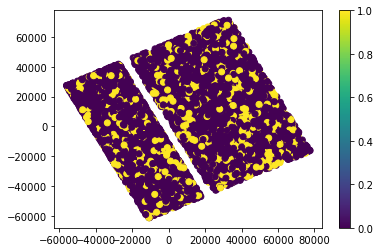

In [26]:
plt.scatter(xtrain_pca[:,0], xtrain_pca[:,1], c=ytrain)
plt.colorbar()
plt.show()

## <a id="processing"> III) Processing</a>

As you may have noticed, various variables are categorical and encoded with strings. Most models won't be able to take them as input.

### Code 2: Transform the categorical data into integers using the encoding of your choice.

_Hint: The simplest methods is called "Label Encoding". It simply consists in replacing each new category you encounter by the integer, starting from 0. It may not be the most efficient method._

In [27]:
# xtrain_final = xtrain_encoded[selected_columns]
xtrain_final = xtrain_preprocess
ytrain_final = ytrain

# xvalid_final = xvalid_encoded[selected_columns]
xvalid_final = xvalid_preprocess
yvalid_final = yvalid

print(xtrain_final.shape, ytrain_final.shape)
print(xvalid_final.shape, yvalid_final.shape)

(11188, 345) (11188,)
(2797, 345) (2797,)


## <a id="model"> IV) Predictive model</a>
Train a model and assess its performance.

### Random Forest Classifier model

In [28]:
# Baseline: Random Forest
clf = RandomForestClassifier(random_state = 42,
    n_estimators=10, class_weight="balanced",
    max_depth=5, 
#     min_samples_split=10,
#     min_samples_leaf=10,
#     max_leaf_nodes=20,
)


clf.fit(xtrain_final, ytrain_final)  # training

ypred = clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6577744413807775


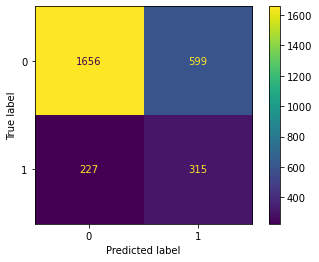

In [29]:
plot_confusion_matrix(clf, xvalid_final, yvalid_final)

In [30]:
n_components = np.arange(start=10, stop=300, step=10)
pca_scores = []

for n_component in n_components:
    pca_clf = RandomForestClassifier(random_state=42, 
        n_estimators=10, class_weight="balanced",
        max_depth=5, 
    )

    pca_clf.fit(xtrain_pca[:, :n_component], ytrain_final)  # training

    pca_predictions = pca_clf.predict(pca_model.transform(xvalid_final)[:, :n_component])  # predictions
    pca_scores.append(balanced_accuracy_score(yvalid_final, pca_predictions))  # scoring
    


Text(0, 0.5, 'valid balanced accuracy')

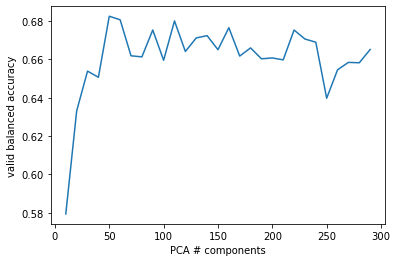

In [31]:
plt.plot(n_components, pca_scores)
plt.xlabel("PCA # components")
plt.ylabel("valid balanced accuracy")

In [32]:
#the list of index ordered by values of pca_scores asc
sorted(range(len(pca_scores)), key=lambda k: pca_scores[k])

[0,
 1,
 24,
 3,
 2,
 25,
 27,
 26,
 9,
 20,
 18,
 19,
 7,
 16,
 6,
 11,
 14,
 28,
 17,
 23,
 22,
 12,
 13,
 21,
 8,
 15,
 10,
 5,
 4]

In [33]:
print('n_components: ', n_components[4], ' and pca_scores: ', pca_scores[4])

n_components:  50  and pca_scores:  0.6825124160332512


### Code 3: the code above uses a simple "hold out" method to get the validation score. Use cross-validation to get a more stable estimation.

In [34]:
# TODO: cross-validation

In [35]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(clf, xtrain_final, ytrain_final, cv=10, scoring='balanced_accuracy')
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [36]:
print(cv_results['test_score'])
print("The average score of cross Validation: ", cv_results['test_score'].mean())

[0.66122297 0.64692021 0.68577181 0.67114925 0.66933326 0.68772855
 0.66527763 0.62660169 0.67902451 0.65283066]
The average score of cross Validation:  0.664586053711361


### Code 4: Try to improve your score by using at least one of the following methods:

* Hyperparameter search
* Model selection
* Data augmentation

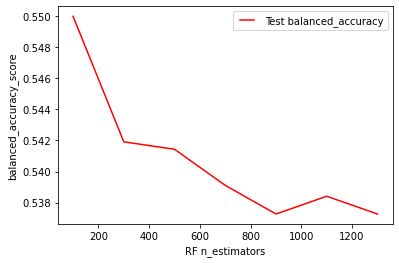

In [37]:
n_estimators = [int(x) for x in range(100,1500,200)]
test_results = []
for n in n_estimators:
    rforest = RandomForestClassifier(random_state = 42, n_estimators = n)
    rforest.fit(xtrain_final, ytrain_final)
    ypred = rforest.predict(xvalid_final)
    accuracy = balanced_accuracy_score(yvalid_final, ypred)
    test_results.append(accuracy)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, test_results, 'r', label="Test balanced_accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('balanced_accuracy_score')
plt.xlabel('RF n_estimators')
plt.show()

In [38]:
#the list of index ordered by values of test_results asc
print(sorted(range(len(test_results)), key=lambda k: test_results[k]))
print(n_estimators[0])

[4, 6, 5, 3, 2, 1, 0]
100


In [39]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in range(100,1500,200)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 8)]
max_depth.append(None)
# number of features at every split
max_features = ['auto', 'sqrt', 'log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
class_weight = [None, 'balanced', 'balanced_subsample']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight
              }
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42,)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10,
                               scoring='balanced_accuracy', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain_final, ytrain_final)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 24, 38, 52, 67, 81,
                                                      95, 110, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500, 700,
                                                         900, 1100, 1300]},
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [40]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'class_weight': 'balanced_subsample'}

In [75]:
rf_clf = RandomForestClassifier(random_state = 42,
    n_estimators = 100, min_samples_split = 2, class_weight= 'balanced_subsample',
    min_samples_leaf = 4, max_features = 'auto', max_depth = 10)


rf_clf.fit(xtrain_final, ytrain_final)  # training

ypred = rf_clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6651622879865162


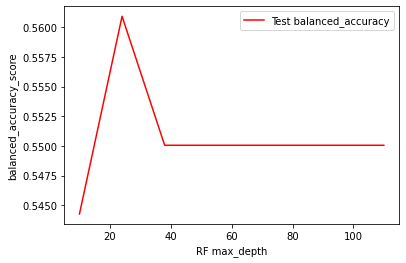

In [42]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 8)]
max_depth.append(None)
test2_results = []
for m in max_depth:
    rforest = RandomForestClassifier(random_state = 42, n_estimators = 10, max_depth = m)
    rforest.fit(xtrain_final, ytrain_final)
    ypred = rforest.predict(xvalid_final)
    accuracy = balanced_accuracy_score(yvalid_final, ypred)
    test2_results.append(accuracy)
from matplotlib.legend_handler import HandlerLine2D
line2, = plt.plot(max_depth, test2_results, 'r', label="Test balanced_accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('balanced_accuracy_score')
plt.xlabel('RF max_depth')
plt.show()

In [46]:
#the list of index ordered by values of test_results asc
print(sorted(range(len(test2_results)), key=lambda k: test2_results[k]))
test2_results[1]

[0, 2, 3, 4, 5, 6, 7, 8, 1]


0.5609048363210904

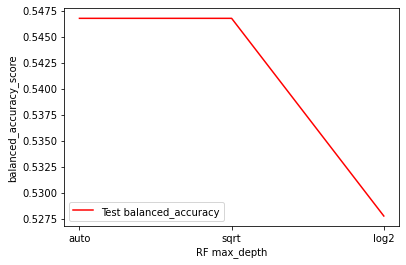

In [47]:
max_features = ['auto', 'sqrt', 'log2']
test3_results = []
for mf in max_features:
    rforest = RandomForestClassifier(random_state = 42, n_estimators = 100, max_depth = 24, max_features=mf)
    rforest.fit(xtrain_final, ytrain_final)
    ypred = rforest.predict(xvalid_final)
    accuracy = balanced_accuracy_score(yvalid_final, ypred)
    test3_results.append(accuracy)
from matplotlib.legend_handler import HandlerLine2D
line3, = plt.plot(max_features, test3_results, 'r', label="Test balanced_accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('balanced_accuracy_score')
plt.xlabel('RF max_depth')
plt.show()

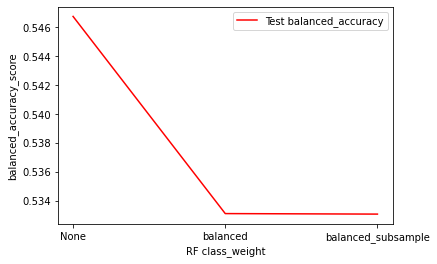

In [48]:
class_weight = [None, 'balanced', 'balanced_subsample']
class_weight2 = ['None', 'balanced', 'balanced_subsample']
test4_results = []
for cw in class_weight:
    rforest = RandomForestClassifier(random_state = 42, n_estimators = 100, max_depth = 24,
                                     max_features='auto', class_weight=cw)
    rforest.fit(xtrain_final, ytrain_final)
    ypred = rforest.predict(xvalid_final)
    accuracy = balanced_accuracy_score(yvalid_final, ypred)
    test4_results.append(accuracy)
from matplotlib.legend_handler import HandlerLine2D
line3, = plt.plot(class_weight2, test4_results, 'r', label="Test balanced_accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('balanced_accuracy_score')
plt.xlabel('RF class_weight')
plt.show()

In [49]:
test4_results[0]

0.5467468765596747

In [50]:
_clf = RandomForestClassifier(random_state = 42,
    n_estimators = 10, min_samples_split = 10, class_weight="balanced",
    min_samples_leaf = 2, max_features = 'sqrt', max_depth = 5)


_clf.fit(xtrain_final, ytrain_final)  # training

_ypred = _clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, _ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6640458677314046


In [51]:
"""from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in range(200,2000,200)]
n_estimators.extend([int(x) for x in range(10,2000,250)])
sorted(n_estimators)

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

#
class_weight = [None, 'balanced', 'balanced_subsample']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42,)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain_final, ytrain_final)

rf_random.best_estimator_
rf_random.best_params_
"""

"from sklearn.model_selection import RandomizedSearchCV\n\n# Number of trees in random forest\nn_estimators = [int(x) for x in range(200,2000,200)]\nn_estimators.extend([int(x) for x in range(10,2000,250)])\nsorted(n_estimators)\n\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt', 'log2']\n\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n\n#\nclass_weight = [None, 'balanced', 'balanced_subsample']\n\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'm

In [52]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = balanced_accuracy_score(y_test, y_pred)
    print (accuracy)
    print(confusion_matrix(y_test,y_pred))
    

#best_random = rf_random.best_estimator_
#evaluate(best_random, xvalid_final, yvalid_final)

In [53]:
from sklearn.model_selection import validation_curve
n_estimators = [100, 300, 500, 750, 800, 1200]
train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = xtrain_final, y = ytrain_final, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators, cv = 3,scoring="balanced_accuracy", n_jobs=1)

In [54]:
#the list of index ordered by values of test_results asc
#print(sorted(range(len(test_score)), key=lambda k: test_score[k]))
print(test_scores)

[[0.54485688 0.53324826 0.53554758]
 [0.52990012 0.53809405 0.53189412]
 [0.53587746 0.52709416 0.53638735]
 [0.5322306  0.53092094 0.53589041]
 [0.5317336  0.53176043 0.5365553 ]
 [0.53023591 0.53042887 0.53289492]]


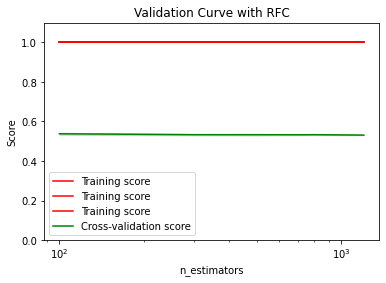

In [57]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RFC")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(n_estimators, train_scores, label="Training score", color="r")
plt.fill_between(n_estimators, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(n_estimators, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(n_estimators, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

### Question 3: What is up-sampling? Why it may be worth a try for this problem?

TODO: answer

In [58]:
# check version number
! pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [59]:
#up-sampling training data 
os = SMOTE(random_state=0)
columns = xtrain_final.columns
os_data_X, os_data_y = os.fit_sample(xtrain_final, ytrain_final)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  17866
Number of no subscription in oversampled data 8933
Number of subscription 8933
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [60]:
rf_random_clf = RandomForestClassifier(random_state = 42,
    n_estimators = 100, min_samples_split = 2, class_weight= 'balanced_subsample',
    min_samples_leaf = 4, max_features = 'auto', max_depth = 10)


rf_random_clf.fit(os_data_X, os_data_y.values.ravel())  # training

ypred = rf_random_clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6501914564600191


In [61]:
# Baseline: Random Forest
clf = RandomForestClassifier(random_state = 42,
    n_estimators=10, class_weight="balanced",
    max_depth=5, 
#     min_samples_split=10,
#     min_samples_leaf=10,
#     max_leaf_nodes=20,
)


clf.fit(os_data_X, os_data_y.values.ravel())  # training

ypred = clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6262831264676283


In [62]:
#tuning hyperparameters for up-sampled training data

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in range(100,1500,200)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 8)]
max_depth.append(None)
# number of features at every split
max_features = ['auto', 'sqrt', 'log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
class_weight = [None, 'balanced', 'balanced_subsample']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight
              }
# Use the random grid to search for best hyperparameters
# First create the base model to tune
uprf = RandomForestClassifier(random_state=42,)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
uprf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10,
                               scoring='balanced_accuracy', cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
uprf_random.fit(os_data_X, os_data_y.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 24, 38, 52, 67, 81,
                                                      95, 110, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500, 700,
                                                         900, 1100, 1300]},
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [63]:
uprf_random.best_params_

{'n_estimators': 1100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'class_weight': 'balanced'}

In [64]:
# Best random forest classifier after up-sampling
up_clf = RandomForestClassifier(random_state = 42,
    n_estimators=1100, class_weight="balanced",
    min_samples_split = 2, min_samples_leaf = 1,
    max_depth=110, max_features = 'sqrt')


up_clf.fit(os_data_X, os_data_y.values.ravel())  # training

ypred = up_clf.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6182620008018263


### Decision Tree Classifier model

In [65]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state= 42)
tree.fit(xtrain_final, ytrain_final)

ypred = tree.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.5895112132939511


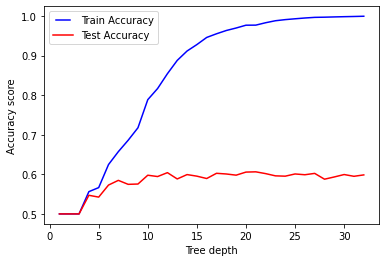

In [66]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(xtrain_final, ytrain_final)
y_pred = dt.predict(xvalid_final)

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(random_state = 42, max_depth=max_depth)
   dt.fit(xtrain_final, ytrain_final)
   train_pred = dt.predict(xtrain_final)
   accuracy = balanced_accuracy_score(ytrain_final, train_pred)
   train_results.append(accuracy)
   y_pred = dt.predict(xvalid_final)
   accuracy = balanced_accuracy_score(yvalid_final, y_pred)
   # Add auc score to previous test results
   test_results.append(accuracy)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(max_depths, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')
plt.show()

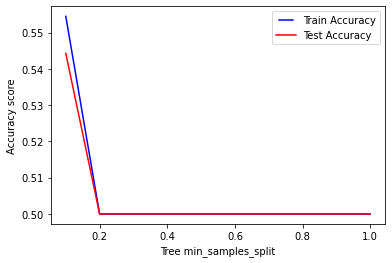

In [67]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(random_state = 42, min_samples_split=min_samples_split)
   dt.fit(xtrain_final, ytrain_final)
   train_pred = dt.predict(xtrain_final)
   accuracy = balanced_accuracy_score(ytrain_final, train_pred)
   train_results.append(accuracy)
   y_pred = dt.predict(xvalid_final)
   accuracy = balanced_accuracy_score(yvalid_final, y_pred)
   # Add auc score to previous test results
   test_results.append(accuracy)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree min_samples_split')
plt.show()

In [71]:
tree_ = DecisionTreeClassifier(random_state = 42, max_depth=1000, max_features=250)


tree_.fit(xtrain_final, ytrain_final)  # training

ypred = tree_.predict(xvalid_final)  # predictions
score = balanced_accuracy_score(yvalid_final, ypred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6162283895566228


## <a id="save"> V) Save Predictions</a>

* Use the following code to make predictions and save them as a ZIP file.
* Try to upload this ZIP file into the competition ("Participate > Submit/ View Results > Submit")
* Do your best to be **on top of the leaderboard!**

In [76]:
xtest_preprocess = preprocess(X_test)
predictions = rf_clf.predict(xtest_preprocess)  # compute predictions (0 and 1)


In [77]:
predictions_file = "mimic_synthetic_test.csv"
pd.Series(predictions).to_csv(predictions_file, index=False, header=False)
print("Predictions saved.")

t = time.asctime().replace(" ", "_").replace(":", "-")
output_file = "./submissions/submission_" + t + ".zip"

# !zip test_submission.zip mimic_synthetic_test.csv # create a ZIP

with ZipFile(output_file, "w") as z:
    z.write(predictions_file)
print("The submission is ready: {}".format(output_file))

Predictions saved.
The submission is ready: ./submissions/submission_Tue_Dec__1_22-53-17_2020.zip


### Interesting to know!

The dataset doesn't contain actual medical data. We are not allowed to share with you such **confidential data** from critical care patients. To avoid that problem, we replaced the data by **artificial data**. 

In order to have credible data, we have generated them using a **Wasserstein GAN**.

For more information, here is a reference: <br />
Privacy Preserving Synthetic Health Data <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />
https://hal.inria.fr/hal-02160496/document